Import Necessary Libraries

In [1]:
from math import sqrt, cos, sin, pi, e
import matplotlib.pyplot as plt
import numpy as np
import random
from pprint import pprint

Create a Box and Particle class/object for ease of retriving positions, velocities, kinetic energy, and to be able to apply a boundry condition simply.

In [2]:
class Box:
    def __init__(self, L) -> None:
        self.L = L
        self.particles = []

    def add_particle(self, vx, vy, m, r):
        self.particles.append(Particle(vx, vy, m, r, self.L))
        

class Particle:
    def __init__(self, vx, vy, m, r, L) -> None:
        self.x = random.uniform(0, L)
        self.y = random.uniform(0, L)
        self.vx = vx
        self.vy = vy
        self.m = m
        self.r = r

    def distance(self, x_other, y_other):
        distance = sqrt((self.x-x_other)**2 + (self.y-y_other)**2)
        return distance
    
    def v(self):
        return sqrt(self.vx**2 + self.vy**2)
    def ke(self):
         return 0.5 * self.m * (self.v()**2)
    
    def update_position(self, dt):
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
    
    def periodic_boundary(self, L):
        if self.x > L:
                self.x -= L
        elif self.x < 0:
                self.x += L
        if self.y > L:
                self.y -= L
        elif self.y < 0:
                self.y += L
    
    def reflective_boundary(self, L):
        if self.x > L:
                self.x = L - (self.x - L)
                self.vx = - self.vx
        elif self.x < 0:
                self.x = - self.x
                self.vx = - self.vx
        if self.y > L:
                self.y = L - (self.y - L)
                self.vy = - self.vy
        elif self.y < 0:
                self.y = -self.y
                self.vy = - self.vy

Necessary functions to check for and run every collision

In [3]:
def get_dt(particles):
    prev = 0
    for particle in particles:
            if particle.v() > prev:
                prev = particle.v()
                r = particle.r
    dt = r/prev
    return dt

def run_collision(particles, i, j):

    # print('iniital momentum:', (particles[i].m + particles[j].m) * ((particles[i].vx + particles[j].vx)+(particles[i].vy + particles[j].vy)))
    # print('KEi =', particles[i].ke() + particles[j].ke())
    theta = random.uniform(0, 2 * pi)

    speed_rel = sqrt((particles[i].vx - particles[j].vx)**2 + (particles[i].vy - particles[j].vy)**2)

    vcomx = ((particles[i].m * particles[i].vx) + (particles[j].m * particles[j].vx))/(particles[i].m + particles[j].m)
    vcomy = ((particles[i].m * particles[i].vy) + (particles[j].m * particles[j].vy))/(particles[i].m + particles[j].m)


    mu = (particles[i].m * particles[j].m)/(particles[i].m + particles[j].m)

    particles[i].vx = vcomx + (mu/particles[i].m) * speed_rel * cos(theta)
    particles[i].vy = vcomy + (mu/particles[i].m) * speed_rel * sin(theta)

    particles[j].vx = vcomx - (mu/particles[j].m) * speed_rel * cos(theta)
    particles[j].vy = vcomy - (mu/particles[j].m) * speed_rel * sin(theta)

    # print('KEf =', particles[i].ke() + particles[j].ke())
    # print('final momentum:', (particles[i].m + particles[j].m) * ((particles[i].vx + particles[j].vx)+(particles[i].vy + particles[j].vy)))

    return

def get_distance_dict(particles):
    ds = {}
    for j in range(len(particles)-1):
        for i in range(j+1, len(particles)):
            d = sqrt((particles[i].x - particles[j].x)**2 + (particles[i].y - particles[j].y)**2)
            string = str(i) + '-' + str(j)
            ds[string] = d

    return ds



def check_collisions(particles, ds, ds_old):
    for j in range(len(particles)-1):
        for i in range(j+1, len(particles)):
            key = str(i) + '-' + str(j)
            d = ds[key]
            d_old = ds_old[key]
            if d < (particles[i].r + particles[j].r) and d <= d_old:
                run_collision(particles, i, j)
                
    return

Functions for plotting and obtaining cumulative data to model a maxwellian curve

In [4]:
def get_cdf(particles):
    ke_list = []
    for particle in particles:
         ke_list.append(particle.ke())

    ke_list.sort()
    cdf = list(range(1, len(ke_list) + 1))
    
    return (ke_list, cdf)

In [5]:
def maxwellian(E, N):
    return N * (1 - e**(-2*E))

Main function for running the system of N particles with a particluar nondimensional velocity and mass for a chosen time in a box with a certain nondimensional length. This way, the problem can be scaled however necessary at a later time. (There is animation that doesn't play in jupyter)

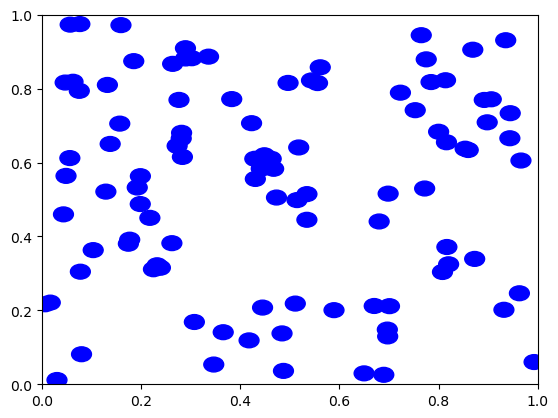

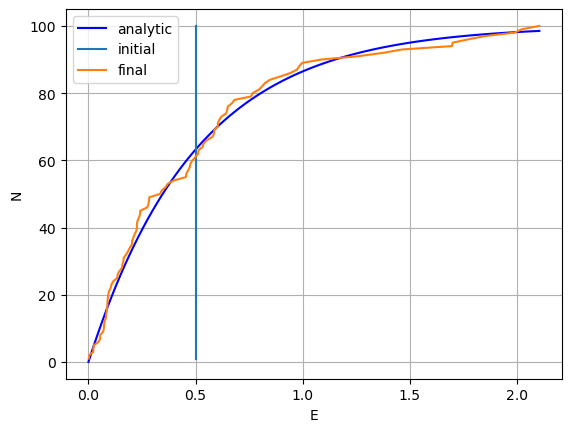

In [6]:
def main():
    N = 100 # num particles
    n = 1000 # num steps
    L = 1 # length of box
    v = 1
    m = 1
    r = 0.02


    box = Box(L)
    for i in range(N):
        theta = random.uniform(0, 2*pi)
        box.add_particle(v*cos(theta), v*sin(theta), m, r)

    particles = box.particles

   
    # Initial Energies
    initial = get_cdf(particles)



    d = get_distance_dict(particles)
    # pprint(d)
    d_old = d


    fig, ax = plt.subplots()
    for i in range(n):
        check_collisions(particles, d, d_old)
        # Calculate delta t
        dt = get_dt(particles)
        for particle in particles:
            particle.update_position(dt)
            # particle.periodic_boundary(L)
            particle.reflective_boundary(L)

        d_old = d
        d = get_distance_dict(particles)


        # animated plot
        ax.clear()
        ax.set_xlim(0, L)
        ax.set_ylim(0, L)
        for particle in particles:
            circle = plt.Circle((particle.x, particle.y), particle.r, color='b', fill=True)
            ax.add_artist(circle)
        plt.pause(0.0005)

    plt.show()
    




    # Final cdf maxwellian
    final = get_cdf(particles)
    # Check against expected/analytic

    Emax = final[0][-1]
    # Generate x values
    x_values = np.linspace(0, Emax, N)
   

    # Calculate y values
    y_values = maxwellian(x_values, N)
   

    # Plot the function
    plt.plot(x_values, y_values, label='analytic', color='blue') # Add color and label


    x1, y1 = initial[0], initial[1]
    x2, y2 = final[0], final[1]
    plt.plot(x1, y1, label = 'initial')
    plt.plot(x2, y2, label = 'final')
    plt.xlabel('E')
    plt.ylabel('N')
    plt.grid(True)
    plt.legend()
    plt.show()
    
main()

This function creates a new system with particles of different masses and radii and runs a similar simulation as above.

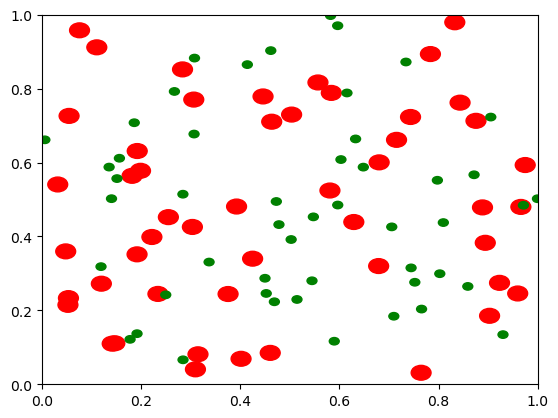

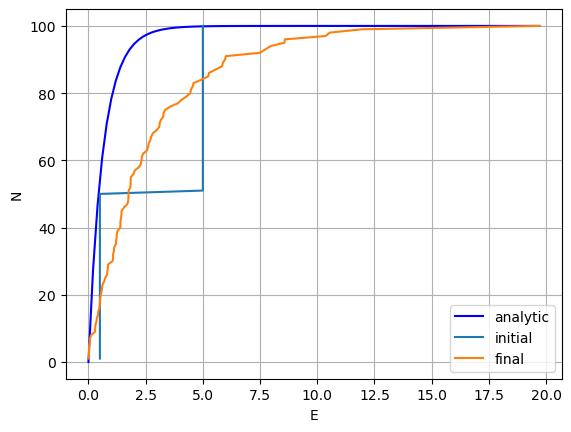

In [7]:
def max_diff(Eb, Es, N):
    N1 = len(Eb)
    N2 = len(Es)
    return (N1 / N) * maxwellian(Eb, N1/2) + (N2/N) * maxwellian(Es, N2/2)


def different_masses():
    L = 1
    v = 1
    r1 = 0.02
    r2 = 0.01
    m1 = 10
    m2 = 1
    N = 100
    n = 1000

    box2 = Box(L)

    for i in range(int(N/2)):
        theta = random.uniform(0, 2*pi)
        box2.add_particle(v*cos(theta), v*sin(theta), m1, r1)
    
    for i in range(N - int(N/2)):
        theta = random.uniform(0, 2*pi)
        box2.add_particle(v*cos(theta), v*sin(theta), m2, r2)


    particles = box2.particles
    big_particles = particles[0:int(len(particles)/2)]
    
    small_particles = particles[int(len(particles)/2):]
  
    # Initial Energies
    initial = get_cdf(particles)


    d = get_distance_dict(particles)
    d_old = d

    fig, ax = plt.subplots()
    for i in range(n):
        check_collisions(particles, d, d_old)
        # Calculate delta t
        dt = get_dt(particles)
        for particle in particles:
            particle.update_position(dt)
            # particle.periodic_boundary(L)
            particle.reflective_boundary(L)

        d_old = d
        d = get_distance_dict(particles)

        # animated plot
        ax.clear()
        ax.set_xlim(0, L)
        ax.set_ylim(0, L)
        for particle in big_particles:
            circle = plt.Circle((particle.x, particle.y), particle.r, color='r', fill=True)
            ax.add_artist(circle)
        for particle in small_particles:
            circle = plt.Circle((particle.x, particle.y), particle.r, color='g', fill=True)
            ax.add_artist(circle)
        plt.pause(0.0005)

    plt.show()

    # Final cdf maxwellian
    final = get_cdf(particles)
    # Check against expected/analytic


    big_Emax = get_cdf(big_particles)[0][-1]
    small_Emax = get_cdf(small_particles)[0][-1]
    Emax = final[0][-1]

    
    # Generate x values
    x_values_big = np.linspace(0, big_Emax, N)
    x_values_small = np.linspace(0, small_Emax, N)
    x_values = np.linspace(0, Emax, N)

    

    # Calculate y values
    y_values = max_diff(x_values_big, x_values_small, N)
  

 
    # Plot the function
    plt.plot(x_values, y_values, label='analytic', color='blue') # Add color and label
    

    x1, y1 = initial[0], initial[1]
    x2, y2 = final[0], final[1]
    plt.plot(x1, y1, label = 'initial')
    plt.plot(x2, y2, label = 'final')
    plt.xlabel('E')
    plt.ylabel('N')
    plt.grid(True)
    plt.legend()
    plt.show()

different_masses()

As seen above, the simulation is not exactly with the analytic maxwellian curve. However, I suspect that this is an error with the analytic curve rather than the simulation. 